# ARIMA Time-Series Forecasting

This notebook takes a look at ARIMA (autoregressive integrated moving average) models used to make time-series predictions and forecasts. 

It follows many excellent references, including:

* [Github Repo](https://github.com/seanabu/seanabu.github.io/blob/master/Seasonal_ARIMA_model_Portland_transit.ipynb) using the same dataset
* Machine Learning Mastery [ARIMA](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) and [SARIMAX](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)
* [These](https://people.duke.edu/~rnau/411arim.htm) [Duke](https://people.duke.edu/~rnau/411arim2.htm) [Pages](https://people.duke.edu/~rnau/411sdif.htm)

The main things included here are:

1. [Visualize the Data](#visualize)
2. [Stationarize](#stationarize)
3. [Find Optimal Parameters](#optimal)
4. [Build Model](#build)
5. [Predict](#predict)
6. [Seasonal Extension](#seasonal)

The basic premise of ARIMA is to use:
* autocorrelations to forecast based on past events
* a built in differencing method to stationarize the data
* a moving average to determine a trend based on past events

In [318]:
# normal stuff
import pandas as pd
import numpy as np

# plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns

# time series
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# metric
from sklearn.metrics import mean_squared_error
 
# extra
import datetime
from dateutil.relativedelta import relativedelta
from numpy.linalg import LinAlgError

# Get rid of warnings
import warnings
warnings.simplefilter('ignore')

<a id='visualize'></a>

---
## Visualize
---

First we just want to see what the data looks like. It appears to have somewhat of an upwards trend overtime, as well as possible seasonalities.

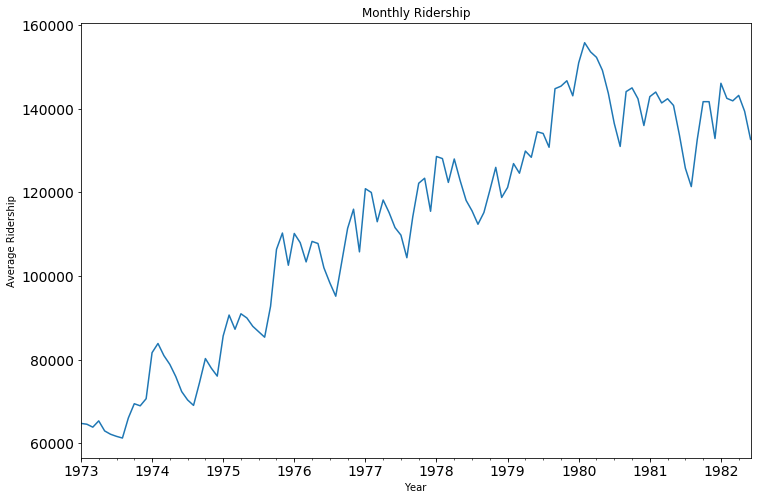

In [74]:
# Load Data
df = pd.read_csv('../Data/portland-oregon-average-monthly-.csv', index_col=0)
df.index.name=None
df.reset_index(inplace=True)
df.drop(df.index[115], inplace=True)
df.drop(df.index[114], inplace=True)

# relabel dates 
start = datetime.datetime.strptime("1973-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,114)]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

# convert back to raw numbers
df.columns= ['riders']
df['riders'] = df.riders.apply(lambda x: int(x)*100)

# print out first few
df.head(10)

# plot ridership
df.riders.plot(figsize=(12,8), title= 'Monthly Ridership', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average Ridership')
plt.show()

<a id='stationarize'></a>

---
## Stationarize
---

Next we want to determine the best way to stationarize the data. 

This is best done with some intuition and a few guideline rules (mostly explained in the Duke pages linked above). Essentially, we would like to difference the data, but not overdifference it. The key point seems to be keeping the lag-1 autocorrelation from going to far negative. 

Other possiblities, such as removing seasonalities or log-valuing the data to remove heteroskedasticity are also possible. 

The stationarity of the data can be tested using a Dickey-Fuller test. Smaller p-value = more likely to be stationary.

When done, we should have an idea of the best value of d to use in the ARIMA model.

Finally, we can also look at the autocorrelations and partial autocorrelations to determine the best starting points for the p and q (autocorrelation and moving average windows, essentially). 

In [176]:
# Consider various stationarizing stuff
# function taken from https://github.com/seanabu/seanabu.github.io/blob/master/Seasonal_ARIMA_model_Portland_transit.ipynb
# however, made some changes to update to more current package/python versions, and slightly updated how it presents
def test_stationarity(timeseries):
    
    timeseries = timeseries.dropna(inplace=False)
    start = timeseries.index[0]
    end = timeseries.index[-1]
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    grid = plt.GridSpec(3, 1, wspace=0., hspace=0., figure=fig)
    plt.subplot(grid[:2, 0])
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.xlim([start, end])
    plt.legend(loc='best')
    plt.ylabel('MEAN')
    plt.title('Rolling Mean & Standard Deviation')
    
    plt.subplot(grid[2, 0])
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.xlim([start, end])
    plt.ylabel('STD')
    plt.legend(loc='best')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    print('------------------------------')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    dfoutput['#Lags Used']=dfoutput['#Lags Used'].astype(int)
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    #print(dfoutput)
    for row_name in list(dfoutput.index):
        if row_name in ['#Lags Used', 'Number of Observations Used']:
            print(row_name.ljust(30), '{:d}'.format(int(dfoutput[row_name])))
        else:
            print(row_name.ljust(30), '{:0.3g}'.format(dfoutput[row_name]))
    #return dfoutput
    
# simply plot the autocorrelation and partial correlations     
def correlation_plots(timeseries):
    
    timeseries = timeseries.dropna(inplace=False)
    
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(timeseries.iloc[:], lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(timeseries.iloc[:], lags=40, ax=ax2)
    plt.show()

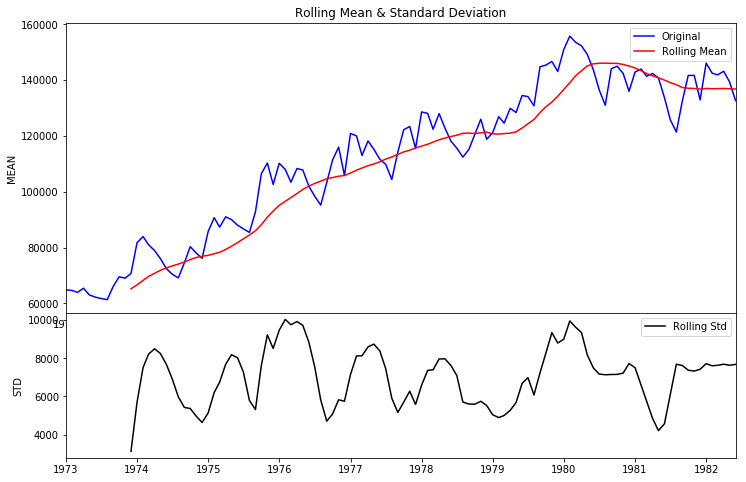

Results of Dickey-Fuller Test:
------------------------------
Test Statistic                 -1.54
p-value                        0.515
#Lags Used                     12
Number of Observations Used    101
Critical Value (1%)            -3.5
Critical Value (5%)            -2.89
Critical Value (10%)           -2.58


In [154]:
# First let's just look at the original data
# We do a 12 month rolling average to compare and a Dickey Fuller Test to see if the model is stationary. It is not...
column='riders'
test_stationarity(df[column])

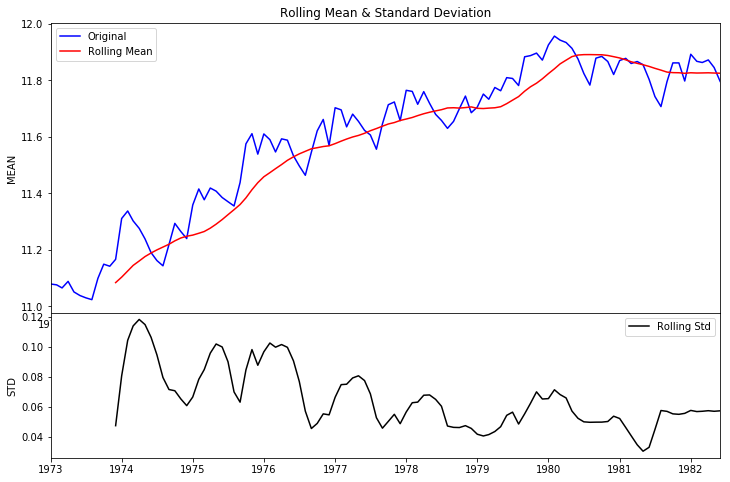

Results of Dickey-Fuller Test:
------------------------------
Test Statistic                 -1.68
p-value                        0.443
#Lags Used                     12
Number of Observations Used    101
Critical Value (1%)            -3.5
Critical Value (5%)            -2.89
Critical Value (10%)           -2.58


In [155]:
# Let's try other methods of stationarizing...
# Log it?
# Still doesn't do great...
column = 'riders_log'
df[column]= df.riders.apply(lambda x: np.log(x))  
test_stationarity(df[column])

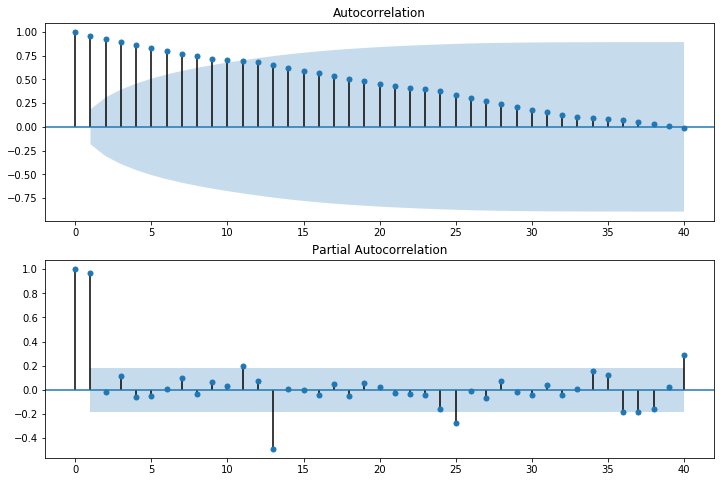

In [124]:
# To determine # of differences to use, often useful to look at the autocorrelations
# We see this thing has very positive autocorrelations, so we will probably need multiple orders of differencing
column = 'riders'
correlation_plots(df[column])

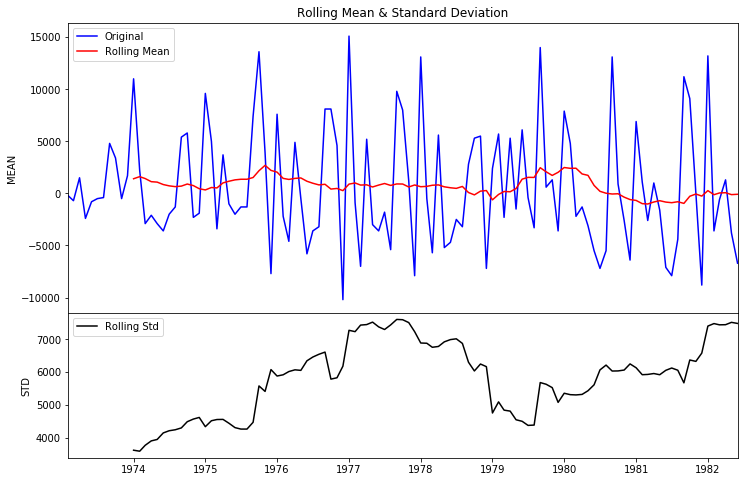

Results of Dickey-Fuller Test:
------------------------------
Test Statistic                 -1.94
p-value                        0.314
#Lags Used                     11
Number of Observations Used    101
Critical Value (1%)            -3.5
Critical Value (5%)            -2.89
Critical Value (10%)           -2.58


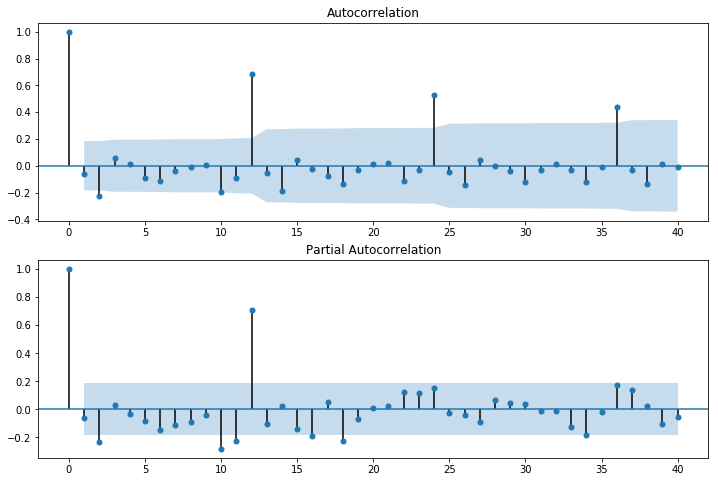

In [156]:
# first difference... starting to look better (note the yearly peaks)
column = 'first_difference'
df[column] = df.riders - df.riders.shift(1)
test_stationarity(df[column])
correlation_plots(df[column])

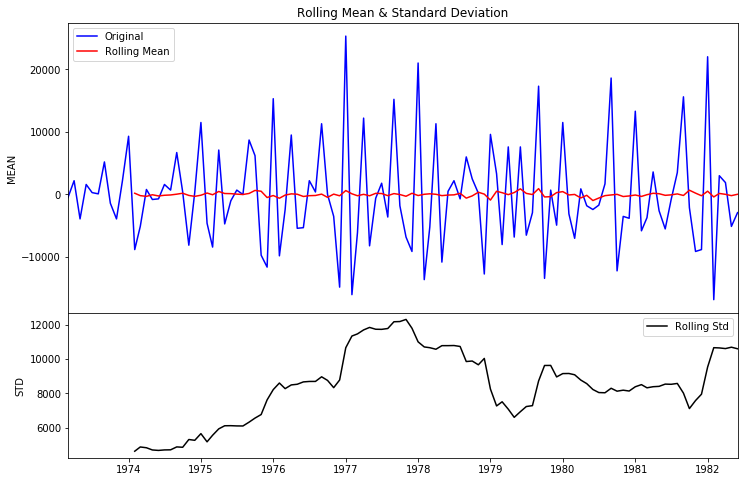

Results of Dickey-Fuller Test:
------------------------------
Test Statistic                 -12.5
p-value                        3.13e-23
#Lags Used                     10
Number of Observations Used    101
Critical Value (1%)            -3.5
Critical Value (5%)            -2.89
Critical Value (10%)           -2.58


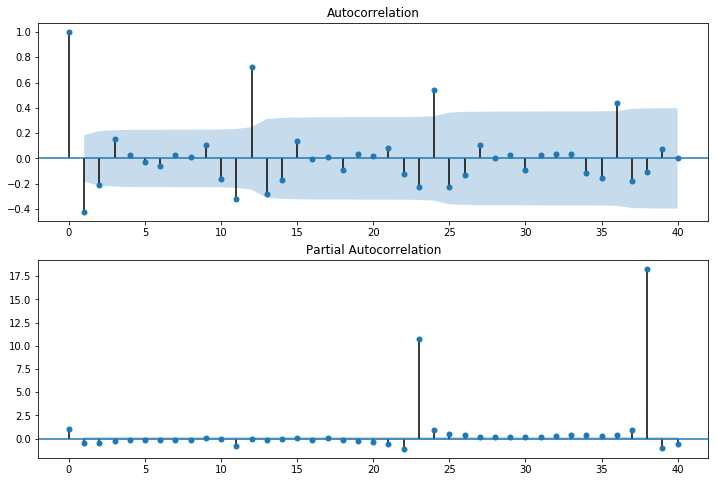

In [157]:
# note that the first autocorrelation has now gone negative, so further differencing will probably overdifferencing
# second difference... 
# note that this is defined as in the notes: y_t - 2*y_t-1 + y_t-2
# looking slightly better but residuals still have some pattern
# p-value is super small? 
# there also appears to be a seasonal trend: larger correlations every 12
column = 'second_difference'
df[column] = df.riders - 2*df.riders.shift(1) + df.riders.shift(2)
test_stationarity(df[column])
correlation_plots(df[column])

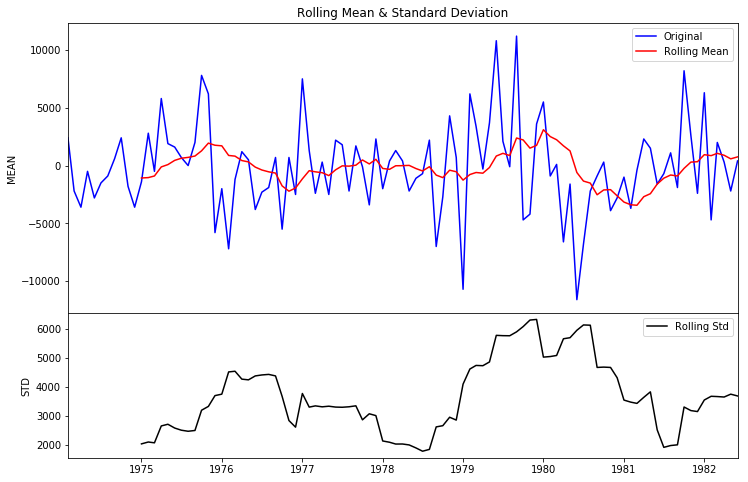

Results of Dickey-Fuller Test:
------------------------------
Test Statistic                 -9.26
p-value                        1.43e-15
#Lags Used                     0
Number of Observations Used    100
Critical Value (1%)            -3.5
Critical Value (5%)            -2.89
Critical Value (10%)           -2.58


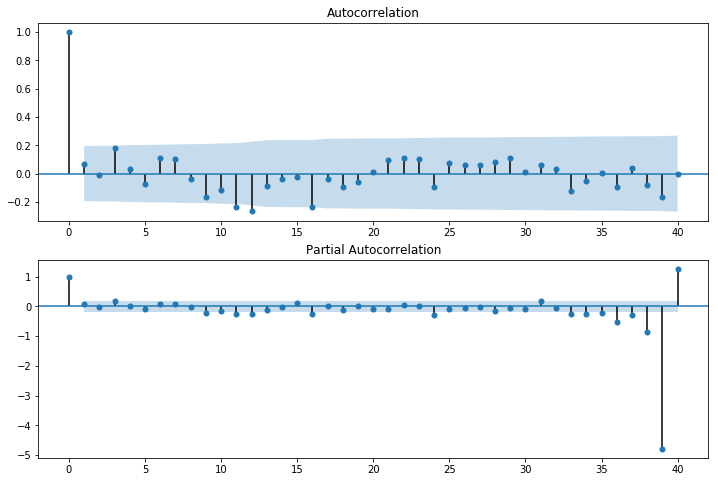

In [162]:
# let's stick to first difference and look at getting rid of seasonalities too
# try to get rid of the yearly seasonalities?
column = 'seasonal_first_difference'
df[column] = df.first_difference - df.first_difference.shift(12)
test_stationarity(df[column])
correlation_plots(df[column])

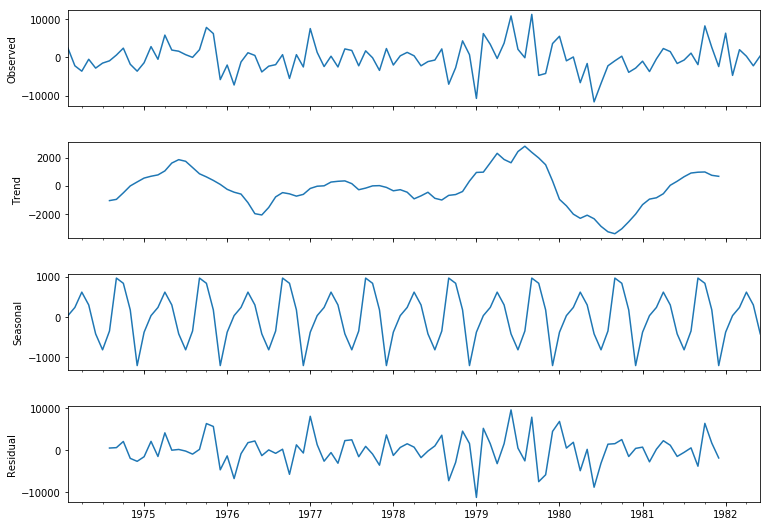

In [253]:
# hoq does the seasonal decompostion look? 
column = 'seasonal_first_difference'
decomposition = seasonal_decompose(df[column].dropna(inplace=False), freq=12)  
#fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 8)
plt.show()

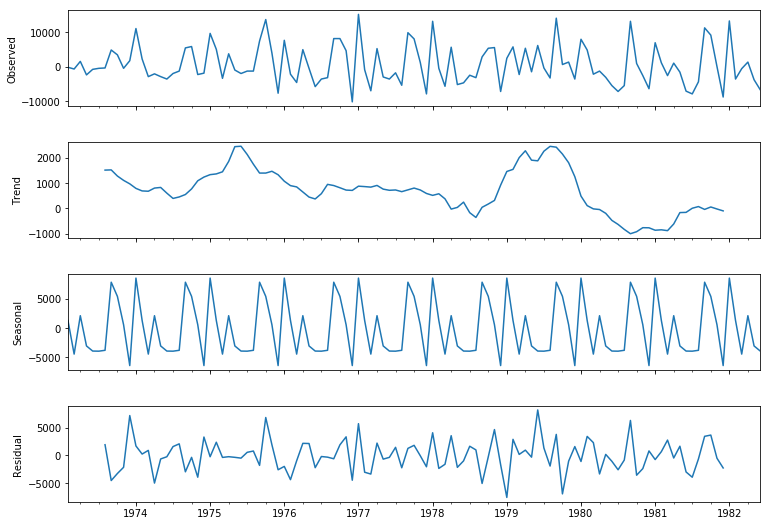

In [254]:
# different seasonal decompostion? 
column = 'first_difference'
decomposition = seasonal_decompose(df[column].dropna(inplace=False), freq=12)  
#fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 8)
plt.show()

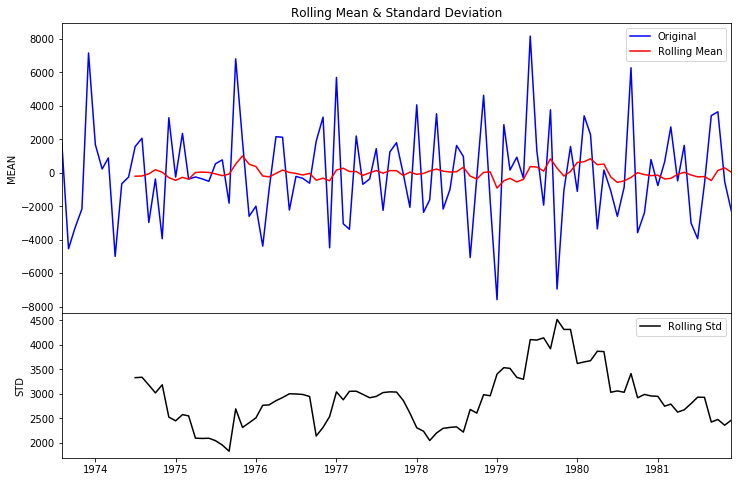

Results of Dickey-Fuller Test:
------------------------------
Test Statistic                 -8.32
p-value                        3.65e-13
#Lags Used                     4
Number of Observations Used    96
Critical Value (1%)            -3.5
Critical Value (5%)            -2.89
Critical Value (10%)           -2.58


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


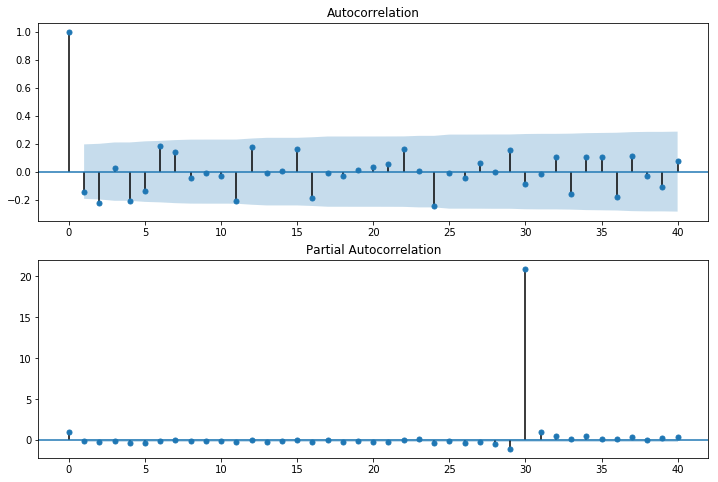

In [262]:
# using the different seasonal decomposition?
# this leads to negative first autocorrelation, which isn't preferred
column = 'seasonal_first_difference_v2'
df[column] = decomposition.resid
test_stationarity(df[column])
correlation_plots(df[column])

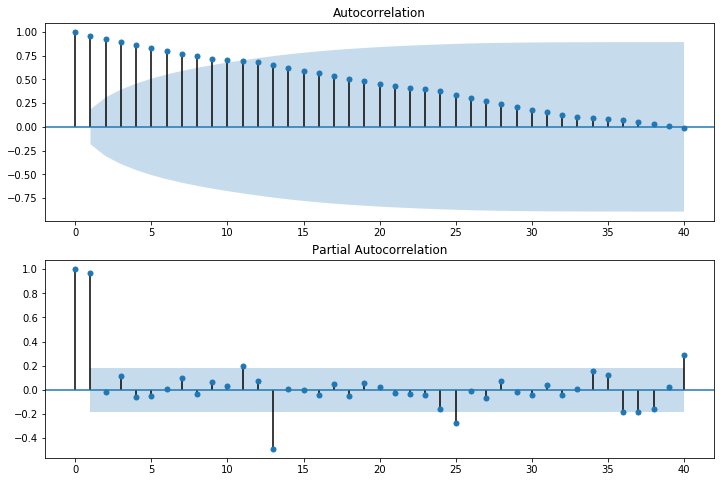

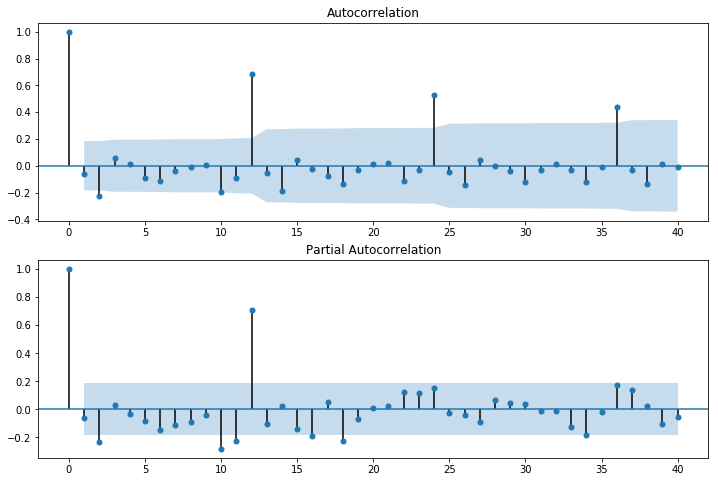

In [263]:
# After looking at all these various plots, it looks like a d = 1 model is best (without overdifferencing)
# however, there is still the problem of dealing with seasonality. 
# for now, we will ignore it 
final_choice = 'riders'
final_difference = 'first_difference'
timeseries_final = df[final_choice].dropna(inplace=False)
correlation_plots(timeseries_final)

correlation_plots(df[final_difference])

<a id='optimal'></a>

---
## Find Optimal Parameters
---

Looking above, it seems that for this particular dataset, a d=1 model should be reasonable (d=2 may be overdifferencing). We start with this value and move on to attempting to fit the model.

Typically, we would wish to work with the "Box and Jenkins method" to determine the optimal p and q. Howwever, there is no obvious pattern in the ACF plot nor the PACF plot for the d=1 shifts. So instead we do a grid search through some possible p and q values, and use the lowest AIC score from the model to determine the best parameters.

In [305]:
# There isn't really any pattern to the ACF or PACF plots for d=1, so not sure where to start with the 'Box and Jenkins' method.
#  instead, choose d = 1 then do a grid search over p and q
# fit model, using AIC as test for best model

# note that we will need a try-except block to catch failing models that can't be solved for
# need to catch linalgerrors...

size = int(len(timeseries_final) * 0.66)
train, test = timeseries_final[0:size], timeseries_final[size:len(timeseries_final)]

p_list = [0, 1, 2, 3, 4, 5]
q_list = [0, 1, 2, 3, 4, 5]
d = 1

results = []

p_best = 0
q_best = 0
aic_best = 1e10

for p in p_list:
    for q in q_list:
        model = ARIMA(train, order=(p,d,q))
        try:
            model_fit = model.fit(disp=0)
            aic = model_fit.aic
        except (ValueError, LinAlgError):
            aic = np.nan
        
        results.append([p,q,d,aic])
        
        if aic<aic_best:
            aic_best = aic
            p_best = p
            q_best = q
            d_best = d
        
        print('\rp = {:d} ** d = {:d} ** q = {:d} ** aic = {:0.4g}'.format(p,d,q,aic),end='')


results_df = pd.DataFrame(results, columns = ['p','q','d','aic'])

print('')
print('-----------')
print('Best Model:')
print('-----------')
print('p   = {:d}'.format(p_best))
print('d   = {:d}'.format(d_best))
print('q   = {:d}'.format(q_best))
print('aic = {:0.4g}'.format(aic_best))

p = 5 ** d = 1 ** q = 5 ** aic = nan
-----------
Best Model:
-----------
p   = 0
d   = 1
q   = 5
aic = 1480


<a id='build'></a>

---
## Build Final Model
---

Once we have our final model parameters, we can build the model and look at some of the statistics, predictions, and forecasts below. 

                             ARIMA Model Results                              
Dep. Variable:               D.riders   No. Observations:                  113
Model:                 ARIMA(0, 1, 5)   Log Likelihood               -1131.701
Method:                       css-mle   S.D. of innovations           5402.346
Date:                Sun, 12 May 2019   AIC                           2277.402
Time:                        20:20:04   BIC                           2296.494
Sample:                    02-01-1973   HQIC                          2285.150
                         - 06-01-1982                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            671.0456    233.365      2.876      0.005     213.660    1128.432
ma.L1.D.riders    -0.1211      0.093     -1.296      0.198      -0.304       0.062
ma.L2.D.riders    -0.2653      0.096

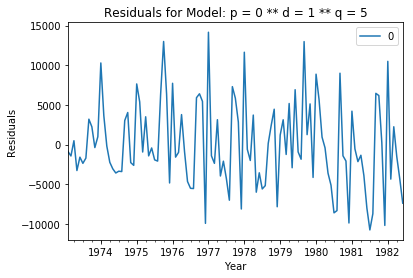

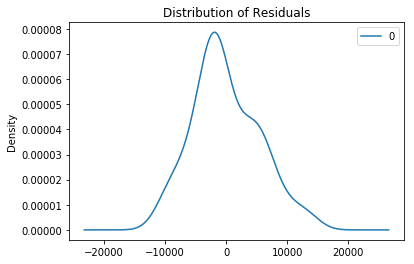

                  0
count    113.000000
mean     -20.278146
std     5427.235706
min   -10773.341935
25%    -3566.480837
50%     -989.944731
75%     3716.443332
max    14166.460682


In [306]:
# fit final model
model = ARIMA(timeseries_final, order=(p_best,d_best,q_best))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Residuals for Model: p = {:d} ** d = {:d} ** q = {:d}'.format(p_best,d_best,q_best))
plt.show()
residuals.plot(kind='kde')
plt.title('Distribution of Residuals')
plt.show()
print(residuals.describe())

<a id='predict'></a>

---
## Make Predictions
---

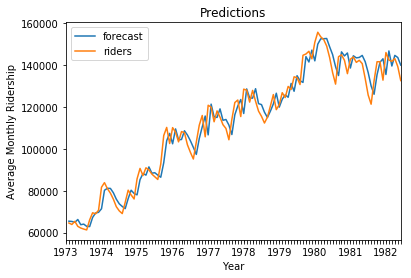

In [307]:
# We can look at how well we are predicting directly
# It looks pretty good!
model_fit.plot_predict()
plt.xlabel('Year')
plt.xticks(timeseries_final.index)
plt.ylabel('Average Monthly Ridership')
plt.title('Predictions')
plt.show()

In [313]:
# We can also produce a dynamic forecast where we only utilize past data to predict a future point
### PROBLEM... get's an error if I use the best fit values as it doesn't think it's stationary... 
# the train set might not work well enough? maybe build model on train first so we know that p_best and q_best will work
history = [x for x in train]
predictions = []
for t in range(len(test)):
	model = ARIMA(history, order=(p_best,d_best,q_best))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast() # forecast the next point
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs) # after passing each point, add its true value to the history being used for the next prediction
	#print('predicted=%f, expected=%f' % (yhat, obs))
predictions = pd.Series(predictions, index=test.index)
#error = mean_squared_error(test, predictions)
#print('Test MSE: %.3f' % error)

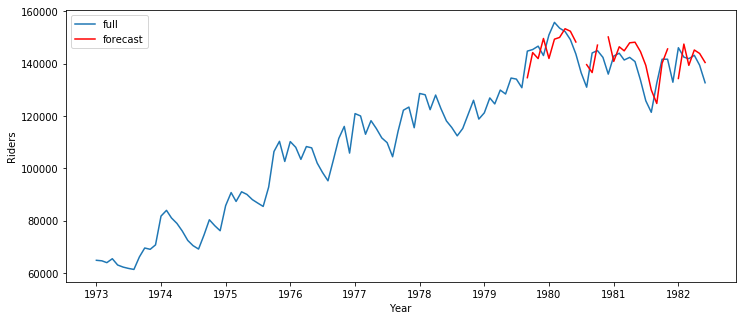

In [314]:
# plot
fig = plt.figure(figsize=(12,5))
plt.plot(timeseries_final, label='full')
#plt.plot(test, label='test')
plt.plot(predictions, color='red', label='forecast')
plt.xlabel('Year')
plt.ylabel('Riders')
plt.legend(loc='best')
plt.show()

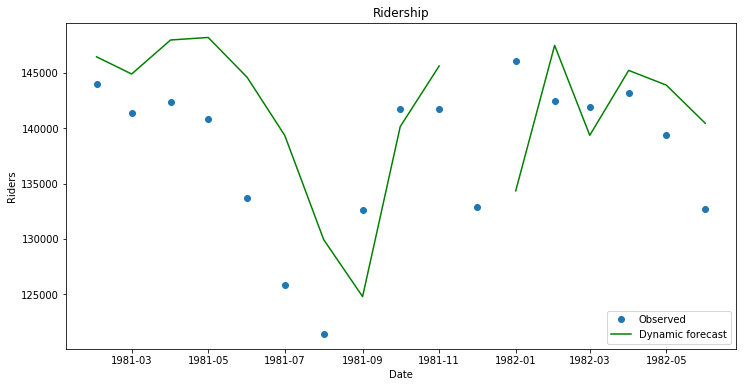

In [315]:
# more plotting
npredict =df.riders['1982'].shape[0]
npre = 12
df['forecast'] = predictions  
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='Ridership', xlabel='Date', ylabel='Riders')
ax.plot(timeseries_final[-npredict-npre+1:], 'o', label='Observed')
ax.plot(df['forecast'][-npredict-npre+1:], 'g', label='Dynamic forecast')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')

<a id='seasonal'></a>

---
## Seasonal Extension: SARIMAX
---

As mentioned before, there appears to be a yearly seasonality in the data. We can attempt to include this using the SARIMAX model, which is the seasonal extension to ARIMA. 

In [319]:
# Now that we've found a reasonable ARIMA model, let's look at the seasonal equivalent. 
# When we looked at the first differencing, there did appear to be a yearly seasonal effect. 
# Let's include it in the model...
# Use SARIMAX

size = int(len(timeseries_final) * 0.66)
train, test = timeseries_final[0:size], timeseries_final[size:len(timeseries_final)]

p_list = [0, 1, 2, 3, 4, 5]
q_list = [0, 1, 2, 3, 4, 5]
d = 1

ps_list = [0, 1, 2, 3, 4, 5]
qs_list = [0, 1, 2, 3, 4, 5]
ds = 1
season = 12

results = []

p_best = 0
q_best = 0
aic_best = 1e10

for p in p_list:
    for q in q_list:
        for ps in ps_list:
            for qs in qs_list:
                model = SARIMAX(train, order=(p,d,q), seasonal_order=(ps, ds, qs, season))
                try:
                    model_fit = model.fit(disp=0)
                    aic = model_fit.aic
                except (ValueError, LinAlgError):
                    aic = np.nan

                results.append([p,q,d, ps, ds, qs, aic])

                if aic<aic_best:
                    aic_best = aic
                    p_best = p
                    q_best = q
                    d_best = d
                    ps_best = ps
                    qs_best = qs
                    ds_best = ds
                    season_best = season

                print('\rp = {:d} ** d = {:d} ** q = {:d} ** ps = {:d} ** ds = {:d} ** qs = {:d} ** aic = {:0.4g}'.format(p,d,q,ps,ds,qs,aic),end='')


results_df = pd.DataFrame(results, columns = ['p','q','d','ps','ds','qs','aic'])

print('')
print('-----------')
print('Best Model:')
print('-----------')
print('p   = {:d}'.format(p_best))
print('d   = {:d}'.format(d_best))
print('q   = {:d}'.format(q_best))
print('ps  = {:d}'.format(ps_best))
print('ds  = {:d}'.format(ds_best))
print('qs  = {:d}'.format(qs_best))
print('aic = {:0.4g}'.format(aic_best))

p = 5 ** d = 1 ** q = 5 ** ps = 5 ** ds = 1 ** qs = 5 ** aic = nan
-----------
Best Model:
-----------
p   = 0
d   = 1
q   = 0
ps  = 3
ds  = 1
qs  = 0
aic = 1184


                                 Statespace Model Results                                 
Dep. Variable:                             riders   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(3, 1, 0, 12)   Log Likelihood                -968.609
Date:                            Sun, 12 May 2019   AIC                           1945.218
Time:                                    20:44:14   BIC                           1955.679
Sample:                                01-01-1973   HQIC                          1949.453
                                     - 06-01-1982                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2716      0.080     -3.407      0.001      -0.428      -0.115
ar.S.L24      -0.2399      0.081   

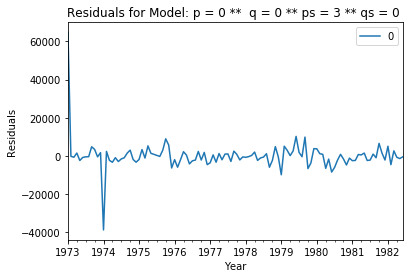

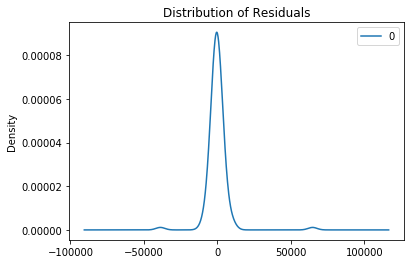

                  0
count    114.000000
mean     -15.420492
std     7876.293368
min   -38782.600255
25%    -2193.143266
50%     -500.815878
75%     1495.322039
max    64800.000000


In [322]:
# fit final model
# the mean of the distribution of residuals is closer to 0 now, with a more normal curve
model = SARIMAX(timeseries_final, order=(p_best,d_best,q_best), seasonal_order=(ps_best, ds_best, qs_best, season_best))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Residuals for Model: p = {:d} **  q = {:d} ** ps = {:d} ** qs = {:d} '.format(p_best,q_best,ps_best,qs_best))
plt.show()
residuals.plot(kind='kde')
plt.title('Distribution of Residuals')
plt.show()
print(residuals.describe())

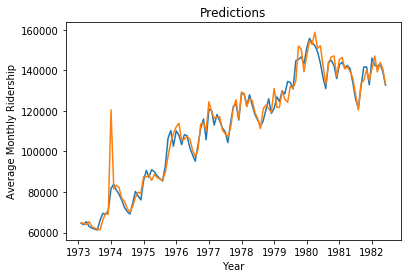

In [325]:
# We can look at how well we are predicting directly
# It looks even better now... except for that weird spike early on. 
pred = model_fit.predict()
plt.plot(timeseries_final[1:])
plt.plot(timeseries_final.index[1:], pred[1:])
plt.xlabel('Year')
plt.ylabel('Average Monthly Ridership')
plt.title('Predictions')
plt.show()

In [326]:
# dynamic forecast...
### PROBLEM... get's an error if I use the best fit values as it doesn't think it's stationary... 
# the train set might not work well enough? maybe build model on train first so we know that p_best and q_best will work
history = [x for x in train]
predictions = []
for t in range(len(test)):
	model = SARIMAX(history, order=(p_best,d_best,q_best), seasonal_order=(ps_best, ds_best, qs_best, season_best))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast() # forecast the next point
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs) # after passing each point, add its true value to the history being used for the next prediction
	#print('predicted=%f, expected=%f' % (yhat, obs))
predictions = pd.Series(predictions, index=test.index)
#error = mean_squared_error(test, predictions)
#print('Test MSE: %.3f' % error)

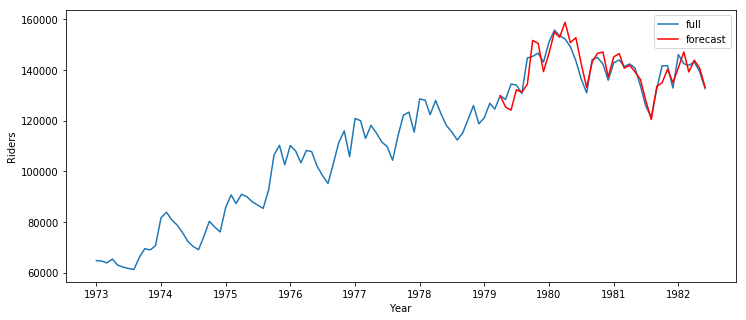

In [327]:
# plot dynamic forecast... 
fig = plt.figure(figsize=(12,5))
plt.plot(timeseries_final, label='full')
#plt.plot(test, label='test')
plt.plot(predictions, color='red', label='forecast')
plt.xlabel('Year')
plt.ylabel('Riders')
plt.legend(loc='best')
plt.show()

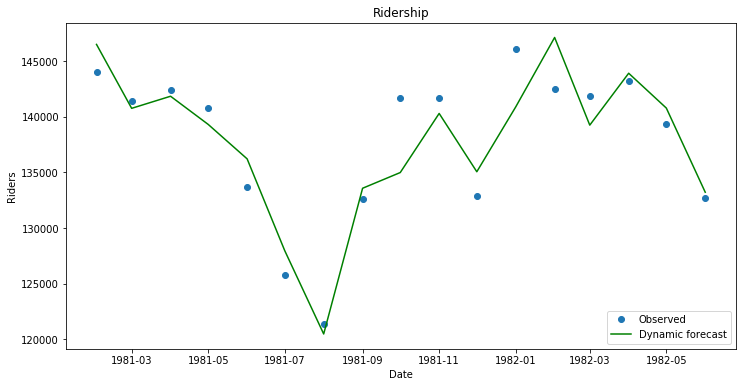

In [328]:
# more plotting
npredict =df.riders['1982'].shape[0]
npre = 12
df['forecast'] = predictions  
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='Ridership', xlabel='Date', ylabel='Riders')
ax.plot(timeseries_final[-npredict-npre+1:], 'o', label='Observed')
ax.plot(df['forecast'][-npredict-npre+1:], 'g', label='Dynamic forecast')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')

As we can see, the seasonal model appears to do a remarkably good job at forecasting new data. 